# LSTM for stock data

Motivation for this notebook is employment of recurrent neural networks, specifically LSTM's for prediction of stock market data. As seen in the previous mandatory notebooks the given data poses as a fairly hard problem for conventional Machine Learning algorithms. As RNN-s are often models of choice for time series data it is reasonable to assume they would have more succes in handling this kind of data. Using PyTorch library a deep learning model will be created, trained on the train set and then finally evaluated on the test set to determine if employment of this approach is effective.

In [160]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch import optim
from matplotlib import pyplot as plt
import seaborn as sns

## Dataset

LSTM will be trained on Adj Close column data. Additionally model will only be trained on a single stock, as that represents a valid time series. Stock is chosen so it has a good balance of positive and negative targets. Data is also scaled using a MinMaxScaler.

In [161]:
data = pd.read_csv('data/clean_data.csv')
data = data.drop(data.columns[0], axis=1)
test_dataset = pd.read_csv('data/test.csv').fillna(0)

In [162]:
symbol = 'IBM'
stock_data = data[data['Symbol'] == symbol]

X = stock_data[['Adj Close']].values.astype(np.float32)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled)

## Data sequences
We create sequences of data that will be "fed" to the LSTM model. This allows us to batch the training data.

In [163]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length:i+seq_length+1]
        sequences.append((seq, target))
    return sequences

## LSTM model

Long Short-Term Memory (LSTM) layers are a fundamental component in many neural network architectures, particularly in tasks involving sequential data like natural language processing (NLP), time series analysis, and speech recognition. They are a type of recurrent neural network (RNN) architecture designed to overcome the limitations of traditional RNNs in capturing long-range dependencies and addressing the vanishing gradient problem.

LSTM layers consist of memory cells that can maintain information over long periods of time. These memory cells have three main components: the input gate, the forget gate, and the output gate. Each gate is composed of a sigmoid neural network layer and a pointwise multiplication operation.

The input gate regulates the flow of information into the memory cell, determining which values from the input and the previous cell state should be updated.
The forget gate controls which information should be discarded from the cell state.
The output gate decides what information from the cell state should be output to the next layer in the network.

Additionally, LSTM layers have a cell state, which acts as a conveyor belt, transporting information throughout the network while being selectively modified by the gates.

During training, LSTM layers learn to retain important information over long sequences and forget irrelevant details, allowing them to model complex temporal dependencies effectively. Their ability to handle vanishing gradients makes them well-suited for training deep networks.

In summary, LSTM layers provide a powerful mechanism for modeling sequential data by allowing neural networks to learn and remember dependencies over extended time periods, making them a cornerstone of many state-of-the-art models in various fields. These kinds of Neural networks work fairly well with time series data, and thus it is likely that they will also work very well with this kind of data. Model comprises 50 hidden LSTM layers, a dropout layer that helps regularize, ReLU activation, and finally a linear layer that provides the output.

In [188]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.view(len(x), 1, -1))
        out = self.dropout(lstm_out.view(len(x), -1))
        out = self.activation(out)
        out = self.fc(out[-1])
        return out


Data is split in 80:20 ratio for training and testing.

In [189]:
sequence_length = 10
sequences = create_sequences(X_scaled, sequence_length)

train_size = int(0.8 * len(sequences))
test_size = len(sequences) - train_size
train_data, test_data = train_test_split(sequences, test_size=test_size, shuffle=False, random_state=42)

Finally model is trained and tested. A hyperparameter grid search optimization could be possible here, but it would take a lot of time and computer resources so a subset of hyperparameters will be manually tested.

Epoch [1/25], Loss: 0.0468
Epoch [2/25], Loss: 0.0517
Epoch [3/25], Loss: 0.0255
Epoch [4/25], Loss: 0.0358
Epoch [5/25], Loss: 0.0153
Epoch [6/25], Loss: 0.0195
Epoch [7/25], Loss: 0.0358
Epoch [8/25], Loss: 0.0134
Epoch [9/25], Loss: 0.0141
Epoch [10/25], Loss: 0.0118
Epoch [11/25], Loss: 0.0088
Epoch [12/25], Loss: 0.0113
Epoch [13/25], Loss: 0.0189
Epoch [14/25], Loss: 0.0116
Epoch [15/25], Loss: 0.0161
Epoch [16/25], Loss: 0.0074
Epoch [17/25], Loss: 0.0062
Epoch [18/25], Loss: 0.0052
Epoch [19/25], Loss: 0.0056
Epoch [20/25], Loss: 0.0041
Epoch [21/25], Loss: 0.0148
Epoch [22/25], Loss: 0.0076
Epoch [23/25], Loss: 0.0072
Epoch [24/25], Loss: 0.0082
Epoch [25/25], Loss: 0.0047
Accuracy: 0.974
F1 Score: 0.983729662077597


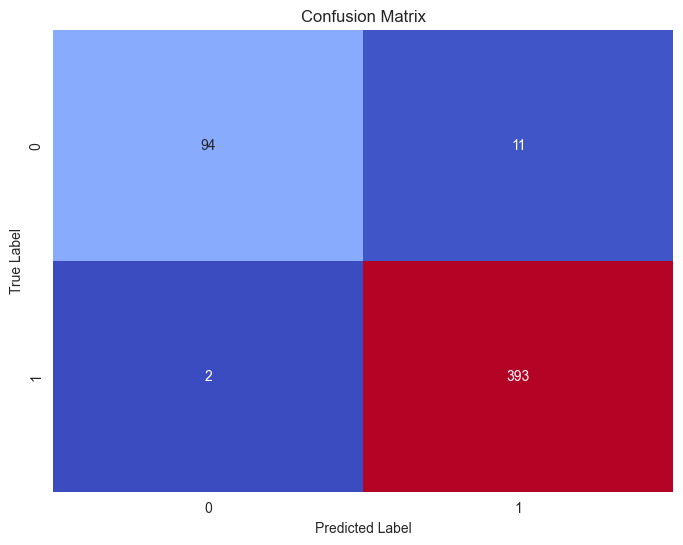

In [197]:
torch.manual_seed(42)
num_epochs = 25
model = LSTMModel(input_size=1)
optimizer = optim.Adam(model.parameters(), lr=0.0003)
for epoch in range(num_epochs):
    loss = 0
    for seq, target in train_data:
        optimizer.zero_grad()
        seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(1)
        y_pred = model(seq_tensor)
        target_tensor = torch.tensor(target[-1], dtype=torch.float32).view(1, 1)
        loss = criterion(y_pred[-1].view(1, 1), target_tensor)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
test_inputs = torch.tensor([seq for seq, _ in test_data], dtype=torch.float32)
test_inputs = test_inputs.view(-1, sequence_length, 1)

with torch.no_grad():
    predicted = [model(seq).item() for seq in test_inputs]
    
target_tensor = torch.tensor([target for _, target in test_data], dtype=torch.float32).view(-1, 1)
actual_labels = np.array([1 if x > 0 else 0 for x in target_tensor])
predicted_labels = np.array([1 if x > 0 else 0 for x in predicted])

accuracy = accuracy_score(actual_labels, predicted_labels)
f1 = f1_score(actual_labels, predicted_labels)
conf_matrix = confusion_matrix(actual_labels, predicted_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

After 25 epochs of training, a **98.3%** F1-score is achieved on the test set. Achieved accuracy reaches **97.4%**. 

Model showed the best performance in current configuration:
- **50** hidden layers
- Dropout layer with **0.1** probability
- ReLU activation
- Adam optimizer with learning rate = **0.0003**
- batch size was set to **10** so the training would be a bit faster and model more robust.

## Conclusion

LSTM model created in this shows a fairly strong performance on the data for a single stock, using just Adj Close column. Strong advantage of this type of model is its high accuracy. On the other hand training is fairly time and resource consuming. 